<a href="https://colab.research.google.com/github/JSJeong-me/AI-Innovation-2024/blob/main/2-2-data_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# tf.data API로 성능 향상하기

<table class="tfo-notebook-buttons" align="left">
  <td data-parent-segment-id="13650222" data-segment-approved="false">     <a target="_blank" href="https://www.tensorflow.org/guide/data_performance"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a>   </td>
  <td data-parent-segment-id="13650223" data-segment-approved="false"><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/guide/data_performance.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td data-parent-segment-id="13650224" data-segment-approved="false"><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/guide/data_performance.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td data-parent-segment-id="13650225" data-segment-approved="false"><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/guide/data_performance.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
</table>

## 개요

GPU와 TPU는 하나의 학습 단계를 실행하는데 필요한 시간을 급격하게 줄일 수 있습니다. 최대 성능을 위해서는 현재 단계가 종료되기 전에 다음 스텝의 데이터를 운반하는 효율적인 입력 파이프라인이 필요합니다.`tf.data` API는 유연하고 효율적인 입력 파이프라인을 만드는데 도움이 됩니다. 이 문서는 다양한 모델과 가속기에서 고성능의 텐서플로 입력 파이프라인을 만드는 방법과 `tf.data` API의 특정을 설명합니다.

진행하기 전에, `tf.data` API 사용법을 익히려면 "[텐서플로 입력 파이프라인 빌드하기](./data.ipynb)" 가이드를 읽으십시오.

## 참고 자료

- [텐서플로 입력 파이프라인 빌드하기](./data.ipynb)
- `tf.data.Dataset` API
- [TF Profiler로 `tf.data` 성능 분석](./data_performance_analysis.md)

## 설정

In [2]:
import tensorflow as tf

import time

전반적인 가이드에서는 데이터셋을 반복하고 성능을 측정합니다. 재현 가능한 성능 벤치마크를 만드는 것은 그것에 영향을 미치는 다른 요인들로 인해 어려울 수 있습니다. 그 요인들로는:

- 현재 CPU 로드,
- 네트워크 트래픽,
- 캐시와 같은 복잡한 메커니즘 등이 있습니다.

따라서 재현 가능한 벤치마크를 제공하기 위해 인공 예제를 빌드합니다.

### 데이터셋

`tf.data.Dataset`에서 상속하여 `ArtificialDataset`이라 불리는 클래스를 정의합니다. 이 데이터셋은:

- `num_samples`(기본값은 3)개의 샘플을 생성하기
- 첫 번째 항목이 파일 열기를 시뮬레이션하기 전에 일정 시간 동안 휴면
- 파일에서 데이터 읽기를 시뮬레이션하기 위해 각 항목을 생성하기 전에 일정 시간 동안 휴면

In [3]:
class ArtificialDataset(tf.data.Dataset):
    def _generator(num_samples):
        # Opening the file
        time.sleep(0.03)

        for sample_idx in range(num_samples):
            # Reading data (line, record) from the file
            time.sleep(0.015)

            yield (sample_idx,)

    def __new__(cls, num_samples=3):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_signature = tf.TensorSpec(shape = (1,), dtype = tf.int64),
            args=(num_samples,)
        )

이 데이터셋은 `tf.data.Dataset.range`와 유사하며 각 샘플의 시작과 사이에 일정한 지연시간을 추가합니다.

### 훈련 루프

데이터셋을 반복하는 데 걸리는 시간을 측정하는 더미 훈련 루프를 작성합니다. 훈련 시간이 시뮬레이션됩니다.

In [4]:
def benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for sample in dataset:
            # Performing a training step
            time.sleep(0.01)
    print("Execution time:", time.perf_counter() - start_time)

## 성능 최적화

성능을 최적화하는 방법을 보여주기 위해 `ArtificialDataset`의 성능을 향상시킵니다.

### 추상적 접근

트릭 없이 추상적 파이프라인으로 시작하여 데이터셋을 그대로 반복합니다.

In [5]:
benchmark(ArtificialDataset())

Execution time: 0.34466718600000945


실제로는 다음과 같이 실행 시간이 소비되었습니다:

![Naive](https://www.tensorflow.org/guide/images/data_performance/naive.svg)

이를 포함한 훈련 스텝을 수행하는 것을 볼 수 있습니다:

- 아직 열지 않은 경우 파일 열기,
- 파일에서 데이터 항목을 가져오기,
- 훈련할 데이터 사용하기.

그러나 여기와 같은 추상적 동기 구현에서는 파이프라인이 데이터를 가져 오는 동안 모델이 유휴 상태입니다. 반대로, 모델이 훈련하는 동안 입력 파이프라인이 유휴 상태입니다. 따라서 훈련 스텝 시간은 모두 열기, 읽기 및 훈련 시간의 합계입니다.

다음 섹션에서는 이 입력 파이프라인을 구축하여 성능이 뛰어난 텐서플로 입력 파이프라인 설계를 위한 모범 사례를 보여줍니다.

### 가져오기(Prefetching)

Prefetching overlaps the preprocessing and model execution of a training step. While the model is executing training step `s`, the input pipeline is reading the data for step `s+1`. Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data.

`tf.data` API는 `tf.data.Dataset.prefetch` 변환을 제공합니다. 이를 이용해 데이터가 생성되는 시간과 데이터가 소비되는 시간을 분리할 수 있습니다. 특히 변환에 백그라운드 스레드와 내부 버퍼를 사용하여 요청된 시간보다 앞서 입력 데이터세트에서 요소를 미리 가져옵니다. 미리 가져올 요소의 수는 단일 학습 단계에서 사용되는 배치 수와 같거나 더 많아야 합니다. 이 값을 수동으로 조정하거나, `tf.data` 런타임이 런타임에 값을 동적으로 조정하도록 `tf.data.AUTOTUNE`로 설정할 수 있습니다.

프리페치 변환은 "생산자"의 작업과 "소비자"의 작업을 겹칠 기회가 있을 때마다 이점을 제공합니다.

In [6]:
benchmark(
    ArtificialDataset()
    .prefetch(tf.data.AUTOTUNE)
)

Execution time: 0.3963000379999926


![Prefetched](https://www.tensorflow.org/guide/images/data_performance/prefetched.svg)

이번에는 훈련 스텝이 샘플 0에 대해 실행되는 동안 입력 파이프라인이 샘플 1에 대한 데이터를 읽고 등등 하는 방식을 볼 수 있습니다.

### 데이터 추출 병렬화

실제 환경에서는 입력 데이터가 로컬에 맞지 않거나 학습이 분산되어 있고 입력 데이터를 모든 컴퓨터에 복제하는 것은 적절하지 않기 때문에 입력 데이터를 원격으로(이를테면, GCS나 HDFS) 저장할 수 있습니다. 데이터를 로컬에서 읽는 데이터셋 파이프라인은 다음과 같은 로컬과 원격 저장소의 차이 때문에 원격으로 데이터를 읽을 때 입출력에 병목이 발생할 수 있습니다:

- **첫 번째 바이트(Time-to-first-byte):** 원격 저장소에서 파일의 첫 번째 바이트를 읽는 것은 로컬 저장소에서 읽어 들이는 것보다 훨씬 오래 걸립니다.
- **읽기 처리량(Read throughput):** 원격 저장소는 보통 큰 총 대역폭을 가지지만 하나의 파일을 읽을 때 이 대역폭의 일부만 활용할 수 있습니다.

게다가 바이트들이 메모리로 읽혀지면 데이터를 역직렬화 그리고/또는 해독할 필요가 있을 수 있습니다(예를 들면, [protobuf](https://developers.google.com/protocol-buffers/)). 이 작업은 추가적인 계산이 필요합니다. 이 오버헤드는 데이터가 로컬 또는 원격으로 저장되는지와는 관계없이 존재하지만 데이터가 효과적으로 프리페치되지 않으면 원격의 경우에 나빠질 수 있습니다.

다양한 데이터 추출 오버헤드의 영향을 줄이기 위해 `tf.data.Dataset.interleave` 변환은 (데이터 파일 판독기와 같은)다른 데이터셋의 내용을 인터리빙(interleaving)하여 데이터 추출 단계를 병렬화하는데 사용할 수 있습니다. 중첩할 데이터셋은 `cycle_length` 매개변수에 의해 지정될 수 있는 반면, 병렬처리 수준은 `num_parallel_calls` 매개변수에 의해 지정될 수 있습니다. `prefetch`와 `map` 변환과 비슷하게 `interleave` 변환은 `tf.data.experimental.AUTOTUNE`을 지원합니다. 이것은 어떤 수준의 병렬처리가 tf.data 런타임에 사용되는지에 대해 결정합니다.

#### 순차적 인터리브

`tf.data.Dataset.interleave` 변환의 기본 인수는 두 개의 데이터셋에서 단일 샘플을 순차적으로 인터리브합니다.

In [7]:
benchmark(
    tf.data.Dataset.range(2)
    .interleave(lambda _: ArtificialDataset())
)

Execution time: 0.5964568090000029


![순차적 인터리브](https://www.tensorflow.org/guide/images/data_performance/sequential_interleave.svg)

이 그림을 사용하면 `interleave` 변환의 결과를 나타낼 수 있으며 사용가능한 두 데이터셋에서 샘플을 가져오는 것이 가능합니다. 그러나 여기에는 성능 향상이 포함되지 않습니다.

#### 병렬 인터리브

이제 `interleave` 변환의 `num_parallel_calls` 인수를 사용합니다. 이는 여러 병렬 데이터셋을 불러오고, 파일을 여는 데 기다리는 시간을 단축할 수 있습니다.

In [8]:
benchmark(
    tf.data.Dataset.range(2)
    .interleave(
        lambda _: ArtificialDataset(),
        num_parallel_calls=tf.data.AUTOTUNE
    )
)

Execution time: 0.8024311100000006


![병렬 인터리브](https://www.tensorflow.org/guide/images/data_performance/parallel_interleave.svg)

이번에는 읽은 두 데이터셋이 병렬화되어 전역 데이터 처리 시간이 줄어듭니다.

### 데이터 변환 병렬화

데이터를 준비할 때 입력 요소를 사전 처리해야 할 수 있습니다. 이를 위해 `tf.data` API는 입력 데이터세트의 각 요소에 사용자 정의 함수를 적용하는 `tf.data.Dataset.map` 변환을 제공합니다. 입력 요소는 서로 독립적이므로 전처리를 여러 CPU 코어에 걸쳐 병렬화할 수 있습니다. 이를 가능하게 하기 위해 `prefetch` 및 `interleave` 변환과 마찬가지로 `map` 변환은 병렬 처리 수준을 지정하는 `num_parallel_calls` 인수를 제공합니다.

`num_parallel_calls` 인수에 가장 적합한 값을 선택하는 것은 하드웨어, 훈련 데이터의 특성(크기 및 형상 등), 맵 함수 비용, CPU에서 동시에 발생하는 기타 처리 등의 요인에 따라 다릅니다. 간단한 경험적 방법은 사용 가능한 CPU 코어 수를 사용하는 것입니다. 그러나 `prefetch` 및 `interleave` 변환의 경우와 같이 `map` 변환은 `tf.data` 런타임에 사용할 병렬 처리 수준에 대한 결정을 위임하는 `tf.data.AUTOTUNE`을 지원합니다.

In [9]:
def mapped_function(s):
    # Do some hard pre-processing
    tf.py_function(lambda: time.sleep(0.03), [], ())
    return s

#### 순차적 매핑

병렬 처리 없이 `map` 변환을 기본 예제로 사용하여 시작하십시오.

In [10]:
benchmark(
    ArtificialDataset()
    .map(mapped_function)
)

Execution time: 0.6725968880000011


![순차적 매핑](https://www.tensorflow.org/guide/images/data_performance/sequential_map.svg)

[추상적 접근](#The-naive-approach)의 경우 여기에서 열기, 읽기, 전처리(매핑) 및 단일 반복을 위해 훈련 스텝에 소요된 시간이 합산됩니다.

#### 병렬 매핑

이제 동일한 전처리 함수를 사용하지만 여러 샘플에 병렬로 적용하십시오.

In [11]:
benchmark(
    ArtificialDataset()
    .map(
        mapped_function,
        num_parallel_calls=tf.data.AUTOTUNE
    )
)

Execution time: 0.639199185999999


![병렬 매핑](https://www.tensorflow.org/guide/images/data_performance/parallel_map.svg)

이제 그림(plot)에서 전처리 단계가 겹치므로 단일 반복의 전체 시간이 줄어 듭니다.

### 캐시하기

`tf.data.Dataset.cache` 변환은 데이터셋을 메모리 또는 로컬 저장소에 캐시할 수 있습니다. 이렇게하면 각 에포크 동안 실행되는 일부 작업(파일 열기 및 데이터 읽기 등)이 저장됩니다.

In [12]:
benchmark(
    ArtificialDataset()
    .map(  # Apply time consuming operations before cache
        mapped_function
    ).cache(
    ),
    5
)

Execution time: 0.503489524999992


![캐시된 데이터셋](https://www.tensorflow.org/guide/images/data_performance/cached_dataset.svg)

데이터셋을 캐시할 때, `cache` 이전의 변환(파일 열기 및 데이터 읽기와 같은)은 첫 번째 에포크 동안에만 실행됩니다. 다음 에포크에는 `cache` 변환에 의해 캐시된 데이터를 재사용 할 것입니다.

`map` 변환에 전달된 사용자 정의 함수가 비싸면 결과 데이터셋이 여전히 메모리 또는 로컬 스토리지에 적합할 수 있는 한 `map` 변환 후 `cache` 변환을 적용합니다.사용자 정의 함수가 캐시 용량을 넘어서 데이터셋을 저장하는 데 필요한 공간을 늘리면 `cache` 변환 후 데이터셋을 적용하거나 훈련 작업 전에 데이터를 전처리하여 리소스 사용량을 줄입니다.

### 매핑 벡터화

`map` 변환으로 전달된 사용자 정의 함수를 호출하면 사용자 정의 함수의 스케줄링 및 실행과 관련된 오버헤드가 있습니다. 사용자 정의 함수를 벡터화(즉, 한 번에 여러 입력에 대해 작동하도록)하고 `맵`을 변환하기 *전에* `배치` 변환을 적용하는 것이 좋습니다.

이 모범 사례를 설명하는 데 인공 데이터셋은 적합하지 않습니다. 스케줄링 지연은 약 10 마이크로초(10e-6초)로, `ArtificialDataset`에 사용된 수십 밀리초보다 훨씬 짧으므로 그 영향을 보기가 어렵습니다.

이 예제에서는 기본 `tf.data.Dataset.range` 함수를 사용하고 훈련 루프를 가장 간단한 형태로 단순화하십시오.

In [13]:
fast_dataset = tf.data.Dataset.range(10000)

def fast_benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for _ in tf.data.Dataset.range(num_epochs):
        for _ in dataset:
            pass
    tf.print("Execution time:", time.perf_counter() - start_time)

def increment(x):
    return x+1

#### 스칼라 매핑

In [14]:
fast_benchmark(
    fast_dataset
    # Apply function one item at a time
    .map(increment)
    # Batch
    .batch(256)
)

Execution time: 1.2726749760000047


![스칼라 맵](https://www.tensorflow.org/guide/images/data_performance/scalar_map.svg)

위의 그림은 (샘플이 적은) 진행 상황을 보여줍니다. 매핑된 함수가 각 샘플에 적용되어 있음을 알 수 있습니다. 이 기능은 매우 빠르지만 시간 성능에 영향을 주는 약간의 오버헤드가 있습니다.

#### 매핑 벡터화됨

In [15]:
fast_benchmark(
    fast_dataset
    .batch(256)
    # Apply function on a batch of items
    # The tf.Tensor.__add__ method already handle batches
    .map(increment)
)

Execution time: 0.24088996000000407


![벡터화된 맵](https://www.tensorflow.org/guide/images/data_performance/vectorized_map.svg)

이번에는 매핑된 함수가 한 번 호출되어 샘플 배치에 적용됩니다. 이 함수를 실행하는 데 시간이 더 걸릴 수 있지만 오버헤드는 한 번만 나타나므로 전체 시간 성능이 향상됩니다.

### 메모리 사용량(footprint) 줄이기

`interleave`, `prefetch`, `shuffle`을 포함한 많은 변환은 요소들의 내부 버퍼를 유지합니다. 사용자 정의 함수가 `map` 변환에 전달된 경우 요소의 크기가 변경되고 맵 변환의 순서와 버퍼 요소가 메모리 사용에 영향을 줍니다. 일반적으로 순서를 다르게 하는 것이 성능에 도움이 되는 경우 메모리 사용량이 낮아지는 순서를 선택하는 것이 좋습니다.

#### 부분 계산 캐싱

이 변환으로 인해 데이터가 너무 커서 메모리에 맞지 않는 경우를 제외하고 `map` 변환 후 데이터셋을 캐시하는 것이 좋습니다. 매핑된 기능을 시간 소모적인 부분과 메모리 소모적인 부분의 두 부분으로 나눌 수 있다면 교환이 성사될 수 있습니다. 이 경우 아래와 같이 변환을 연결할 수 있습니다:

```python
dataset.map(time_consuming_mapping).cache().map(memory_consuming_mapping)
```

이런 식으로 시간이 많이 걸리는 부분은 첫 번째 에포크(epoch) 동안에만 실행되며 너무 많은 캐시 공간을 사용하지 않습니다.

## 가장 좋은 예제 요약

다음은 성능이 좋은 텐서플로 입력 파이프라인을 설계하기 위한 가장 좋은 예제를 요약한 것입니다:

- [`prefetch` 변환](#Pipelining)을 사용하여 프로듀서와 컨슈머의 작업을 오버랩하세요.
- `interleave` 변환을 이용해 [데이터 읽기 변환을 병렬화하세요](#Parallelizing-data-extraction).
- `num_parallel_calls` 매개변수를 설정하여 [`map` 변환을 병렬 처리하세요](#Parallelizing-data-transformation).
- 데이터가 메모리에 저장될 수 있는 경우, [`cache` 변환을 사용](#Caching)하여 첫 번째 에포크동안 데이터를 메모리에 캐시하세요.
- `map` 변환에 전달된 [사용자 정의 함수를 벡터화](#Map-and-batch)하세요.
- `interleave`, `prefetch`, 그리고 `shuffle` 변환을 적용하여 [메모리 사용을 줄이세요](#Reducing-memory-footprint).

## 그림 재현

참고: 이 노트북의 나머지 부분은 위의 그림을 재현하는 방법에 대한 것이며, 이 코드로 자유롭게 놀아볼 수 있지만 이해하는 것은 이 자습서의 필수적인 부분이 아닙니다.

`tf.data.Dataset` API에 대해 더 깊이 이해하기 위해 자신만의 파이프라인을 사용할 수 있습니다. 다음은 이 안내서의 이미지를 그리는 데 사용되는 코드입니다. 다음과 같은 일반적인 어려움에 대한 해결 방법을 보여주는 좋은 출발점이 될 수 있습니다:

- 실행 시간 재현성;
- 매핑 된 기능 즉시 실행;
- `interleave` 변환 호출 가능.

In [16]:
import itertools
from collections import defaultdict

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

### 데이터셋

`ArtificialDataset`과 비슷하게 각 단계에서 소요된 시간을 리턴하는 데이터셋을 빌드할 수 있습니다.

In [17]:
class TimeMeasuredDataset(tf.data.Dataset):
    # OUTPUT: (steps, timings, counters)
    OUTPUT_TYPES = (tf.dtypes.string, tf.dtypes.float32, tf.dtypes.int32)
    OUTPUT_SHAPES = ((2, 1), (2, 2), (2, 3))

    _INSTANCES_COUNTER = itertools.count()  # Number of datasets generated
    _EPOCHS_COUNTER = defaultdict(itertools.count)  # Number of epochs done for each dataset

    def _generator(instance_idx, num_samples):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[instance_idx])

        # Opening the file
        open_enter = time.perf_counter()
        time.sleep(0.03)
        open_elapsed = time.perf_counter() - open_enter

        for sample_idx in range(num_samples):
            # Reading data (line, record) from the file
            read_enter = time.perf_counter()
            time.sleep(0.015)
            read_elapsed = time.perf_counter() - read_enter

            yield (
                [("Open",), ("Read",)],
                [(open_enter, open_elapsed), (read_enter, read_elapsed)],
                [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, sample_idx)]
            )
            open_enter, open_elapsed = -1., -1.  # Negative values will be filtered


    def __new__(cls, num_samples=3):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=cls.OUTPUT_TYPES,
            output_shapes=cls.OUTPUT_SHAPES,
            args=(next(cls._INSTANCES_COUNTER), num_samples)
        )

이 데이터셋은 `[[2, 1], [2, 2], [2, 3]]`의 크기와 `[tf.dtypes.string, tf.dtypes.float32, tf.dtypes.int32]`의 타입을 가진 샘플을 제공합니다. 각 샘플은:

```
(
  [("Open"), ("Read")],
  [(t0, d), (t0, d)],
  [(i, e, -1), (i, e, s)]
)
```

이며,

- `Open`과 `Read`는 스텝 식별자
- `t0`는 해당 스텝이 시작된 타임스탬프
- `d`는 해당 스텝에서 소비된 시간
- `i`는 인스턴스의 인덱스
- `e`는 에포크 인덱스(데이터셋이 반복된 횟수)
- `s`는 샘플 인덱스입니다.

### 반복 루프

반복 루프를 조금 더 복잡하게 하여 모든 타이밍을 집계하십시오. 위에서 설명한 대로 샘플을 생성하는 데이터셋에서만 작동합니다.

In [18]:
def timelined_benchmark(dataset, num_epochs=2):
    # Initialize accumulators
    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)

    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        epoch_enter = time.perf_counter()
        for (steps, times, values) in dataset:
            # Record dataset preparation informations
            steps_acc = tf.concat((steps_acc, steps), axis=0)
            times_acc = tf.concat((times_acc, times), axis=0)
            values_acc = tf.concat((values_acc, values), axis=0)

            # Simulate training time
            train_enter = time.perf_counter()
            time.sleep(0.01)
            train_elapsed = time.perf_counter() - train_enter

            # Record training informations
            steps_acc = tf.concat((steps_acc, [["Train"]]), axis=0)
            times_acc = tf.concat((times_acc, [(train_enter, train_elapsed)]), axis=0)
            values_acc = tf.concat((values_acc, [values[-1]]), axis=0)

        epoch_elapsed = time.perf_counter() - epoch_enter
        # Record epoch informations
        steps_acc = tf.concat((steps_acc, [["Epoch"]]), axis=0)
        times_acc = tf.concat((times_acc, [(epoch_enter, epoch_elapsed)]), axis=0)
        values_acc = tf.concat((values_acc, [[-1, epoch_num, -1]]), axis=0)
        time.sleep(0.001)

    tf.print("Execution time:", time.perf_counter() - start_time)
    return {"steps": steps_acc, "times": times_acc, "values": values_acc}

### 그리기(plotting) 메서드

마지막으로, `timelined_benchmark` 함수에 의해 리턴된 값이 주어지면 타임라인을 그릴 수 있는 함수를 정의하십시오.

In [19]:
def draw_timeline(timeline, title, width=0.5, annotate=False, save=False):
    # Remove invalid entries (negative times, or empty steps) from the timelines
    invalid_mask = np.logical_and(timeline['times'] > 0, timeline['steps'] != b'')[:,0]
    steps = timeline['steps'][invalid_mask].numpy()
    times = timeline['times'][invalid_mask].numpy()
    values = timeline['values'][invalid_mask].numpy()

    # Get a set of different steps, ordered by the first time they are encountered
    step_ids, indices = np.stack(np.unique(steps, return_index=True))
    step_ids = step_ids[np.argsort(indices)]

    # Shift the starting time to 0 and compute the maximal time value
    min_time = times[:,0].min()
    times[:,0] = (times[:,0] - min_time)
    end = max(width, (times[:,0]+times[:,1]).max() + 0.01)

    cmap = mpl.cm.get_cmap("plasma")
    plt.close()
    fig, axs = plt.subplots(len(step_ids), sharex=True, gridspec_kw={'hspace': 0})
    fig.suptitle(title)
    fig.set_size_inches(17.0, len(step_ids))
    plt.xlim(-0.01, end)

    for i, step in enumerate(step_ids):
        step_name = step.decode()
        ax = axs[i]
        ax.set_ylabel(step_name)
        ax.set_ylim(0, 1)
        ax.set_yticks([])
        ax.set_xlabel("time (s)")
        ax.set_xticklabels([])
        ax.grid(which="both", axis="x", color="k", linestyle=":")

        # Get timings and annotation for the given step
        entries_mask = np.squeeze(steps==step)
        serie = np.unique(times[entries_mask], axis=0)
        annotations = values[entries_mask]

        ax.broken_barh(serie, (0, 1), color=cmap(i / len(step_ids)), linewidth=1, alpha=0.66)
        if annotate:
            for j, (start, width) in enumerate(serie):
                annotation = "\n".join([f"{l}: {v}" for l,v in zip(("i", "e", "s"), annotations[j])])
                ax.text(start + 0.001 + (0.001 * (j % 2)), 0.55 - (0.1 * (j % 2)), annotation,
                        horizontalalignment='left', verticalalignment='center')
    if save:
        plt.savefig(title.lower().translate(str.maketrans(" ", "_")) + ".svg")

### 매핑된 함수용 래퍼(wrappers) 사용

eager 컨텍스트에서 매핑된 함수를 실행하려면 `tf.py_function` 호출 내에서 래핑해야 합니다.

In [20]:
def map_decorator(func):
    def wrapper(steps, times, values):
        # Use a tf.py_function to prevent auto-graph from compiling the method
        return tf.py_function(
            func,
            inp=(steps, times, values),
            Tout=(steps.dtype, times.dtype, values.dtype)
        )
    return wrapper

### 파이프라인 비교

In [21]:
_batch_map_num_items = 50

def dataset_generator_fun(*args):
    return TimeMeasuredDataset(num_samples=_batch_map_num_items)

#### Naive

In [22]:
@map_decorator
def naive_map(steps, times, values):
    map_enter = time.perf_counter()
    time.sleep(0.001)  # Time consuming step
    time.sleep(0.0001)  # Memory consuming step
    map_elapsed = time.perf_counter() - map_enter

    return (
        tf.concat((steps, [["Map"]]), axis=0),
        tf.concat((times, [[map_enter, map_elapsed]]), axis=0),
        tf.concat((values, [values[-1]]), axis=0)
    )

naive_timeline = timelined_benchmark(
    tf.data.Dataset.range(2)
    .flat_map(dataset_generator_fun)
    .map(naive_map)
    .batch(_batch_map_num_items, drop_remainder=True)
    .unbatch(),
    5
)

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


Execution time: 20.889541826


### Optimized

In [23]:
@map_decorator
def time_consuming_map(steps, times, values):
    map_enter = time.perf_counter()
    time.sleep(0.001 * values.shape[0])  # Time consuming step
    map_elapsed = time.perf_counter() - map_enter

    return (
        tf.concat((steps, tf.tile([[["1st map"]]], [steps.shape[0], 1, 1])), axis=1),
        tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [times.shape[0], 1, 1])), axis=1),
        tf.concat((values, tf.tile([[values[:][-1][0]]], [values.shape[0], 1, 1])), axis=1)
    )


@map_decorator
def memory_consuming_map(steps, times, values):
    map_enter = time.perf_counter()
    time.sleep(0.0001 * values.shape[0])  # Memory consuming step
    map_elapsed = time.perf_counter() - map_enter

    # Use tf.tile to handle batch dimension
    return (
        tf.concat((steps, tf.tile([[["2nd map"]]], [steps.shape[0], 1, 1])), axis=1),
        tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [times.shape[0], 1, 1])), axis=1),
        tf.concat((values, tf.tile([[values[:][-1][0]]], [values.shape[0], 1, 1])), axis=1)
    )


optimized_timeline = timelined_benchmark(
    tf.data.Dataset.range(2)
    .interleave(  # Parallelize data reading
        dataset_generator_fun,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(  # Vectorize your mapped function
        _batch_map_num_items,
        drop_remainder=True)
    .map(  # Parallelize map transformation
        time_consuming_map,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    .cache()  # Cache data
    .map(  # Reduce memory usage
        memory_consuming_map,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    .prefetch(  # Overlap producer and consumer works
        tf.data.AUTOTUNE
    )
    .unbatch(),
    5
)

Execution time: 9.002328111999987


<ipython-input-19-c2085563342f>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("plasma")


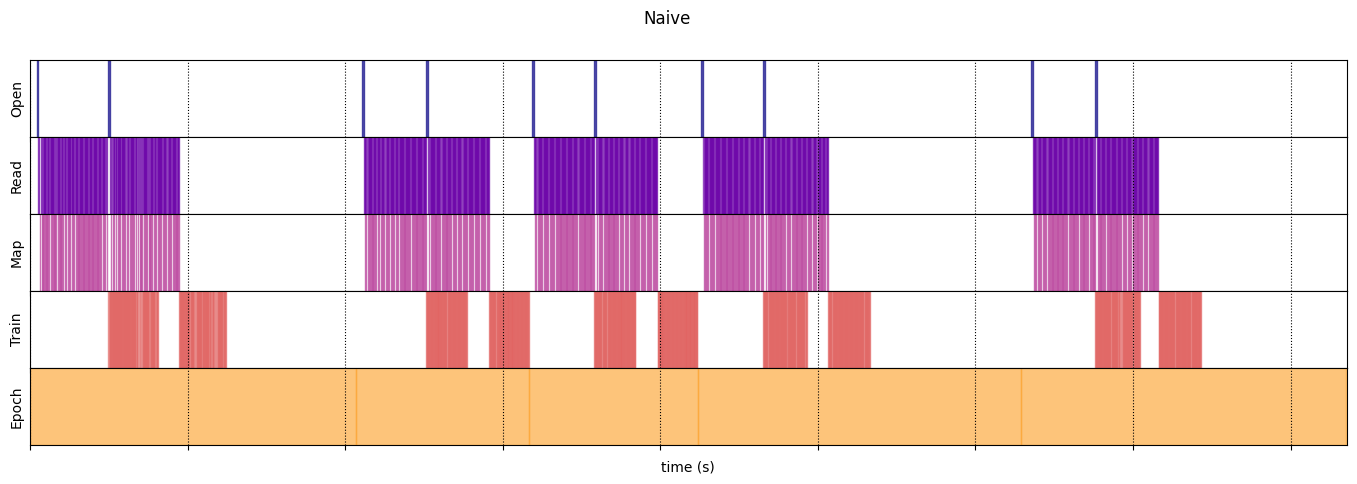

In [24]:
draw_timeline(naive_timeline, "Naive", 15)

<ipython-input-19-c2085563342f>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("plasma")


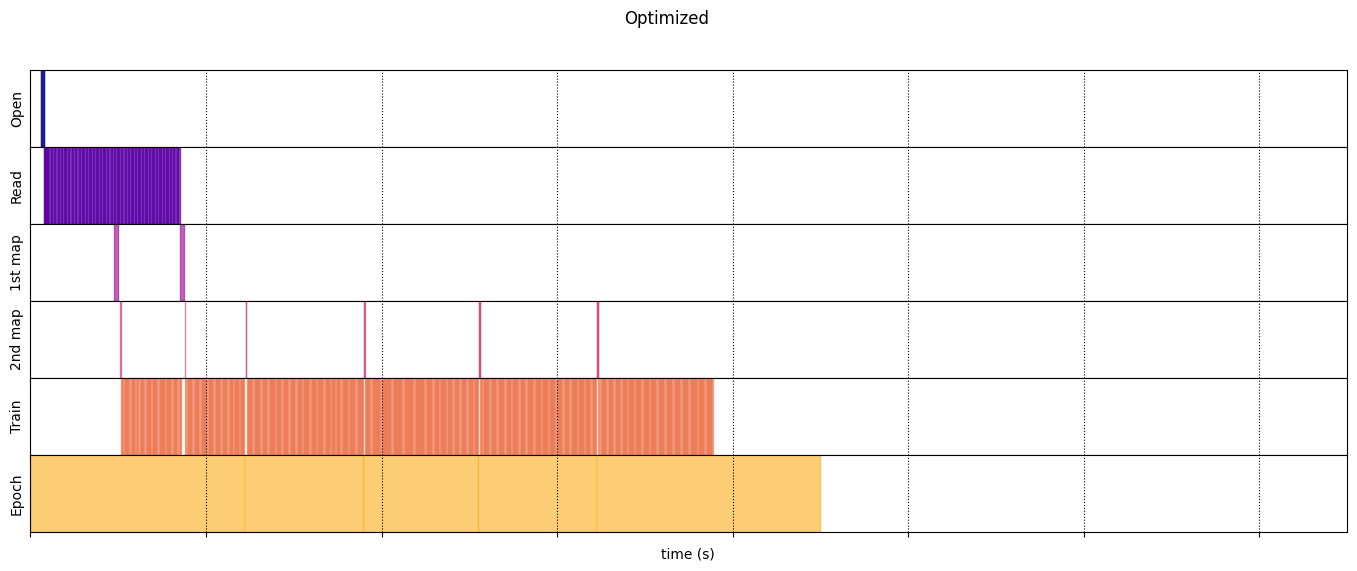

In [25]:
draw_timeline(optimized_timeline, "Optimized", 15)